# InSAR time series for a landslide near Jujuy, Argentina

**--Nicolas Garcia Ospina**

Within this report a time series created from a descending [LiCSAR](https://comet.nerc.ac.uk/comet-lics-portal/) dataset and processed with the [LiCSBAS](https://github.com/yumorishita/LiCSBAS) package is analyzed. Interferograms were corrected with the troposferic delay maps provided by [GACOS](http://www.gacos.net/). The study area is located in the province of Jujuy in the northwestern part of Argentina. This is a vast arid area is affected by seasonality, where the dry and humid seasons extent from May to November and December to April respectively (Bianchi & Yañez 1992; Garreaud & Aceituno 2007; Esper *et al.* 2020) 





- Bianchi D, Yañez A. 1992. Las precipitaciones en el NOA Argentino. Segunda Edición. Salta: INTA.

- Garreaud RD, Aceituno P. 2007. Atmospheric circulation and climatic variability. In: Veblen T, Young R, Orme AR, editors. The physcial geography of South America. Oxford: Oxford University Press; p. 45–59.

- Esper Angillieri, M. Y., Perucca, L., & Vargas, N. (2020). Spatial and temporal analysis of debris flow occurrence in three adjacent basins of the western margin of Grande River: Quebrada de Humahuaca, Jujuy, Argentina. Geografiska Annaler: Series A, Physical Geography, 102(2), 83-103.

- Morishita, Y., Lazecky, M., Wright, T. J., Weiss, J. R., Elliott, J. R., & Hooper, A. (2020). LiCSBAS: An open-source InSAR time series analysis package integrated with the LiCSAR automated Sentinel-1 InSAR processor. Remote Sensing, 12(3), 424.

- Lazecký, M., Spaans, K., González, P. J., Maghsoudi, Y., Morishita, Y., Albino, F., ... & Wright, T. J. (2020). LiCSAR: An automatic InSAR tool for measuring and monitoring tectonic and volcanic activity. Remote Sensing, 12(15), 2430.

- Yu, C., Li, Z., Penna, N., & Crippa, P. (2018, April). Generic Atmospheric Correction Online Service for InSAR (GACOS). In EGU General Assembly Conference Abstracts (p. 11007).

## Individual time series

First of all an individual time series will be recovered to superficially analyze the landslide nature. For this the LiCSBAS cumulative displacement output file `cum_filt.h5` is loaded and a selected pixel is then extracted.

In [1]:
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd
from shapely.geometry import mapping
from rasterio.mask import mask
import rasterio.plot
import matplotlib as mpl
import matplotlib.patches as patches
import os

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Open single pixel txts from LiCSBAS
#not enough info here
# ts_list = open("../010D_11455_131313/ts_377_360.txt").readlines()
# ts_arr = np.loadtxt(fname = "../010D_11455_131313/ts_377_360.txt", skiprows=8, dtype="int, float")

#use hdf5 file
ds = h5py.File("../010D_11455_131313/TS_GEOCml1GACOSmaskclip/cum_filt.h5", "r")

In [3]:
#extract important data
corner_lat = ds["corner_lat"][()]
corner_lon = ds["corner_lon"][()]
post_lat = ds["post_lat"][()]
post_lon = ds["post_lon"][()]
vel = ds["vel"][:,:]
extent = [corner_lon, 
          corner_lon + (post_lon*np.shape(vel)[1]), 
          corner_lat + (post_lat*np.shape(vel)[0]),
          corner_lat]

#Get time series cube
ts_cube = ds["cum"][()] #shape = (bands, rows, cols) -> rasterio likes this

A map of the regional LOS deformation setting is plotted with a close-up to the target landslide, the landslide shows some lobes with higher displacement rates. to the south the highest rate is observed with velocities up to ca. 6cm/year. The selected pixel is located at -24.3682778, -65.6347778, which is a central pixel in the high deformation rate zone. 

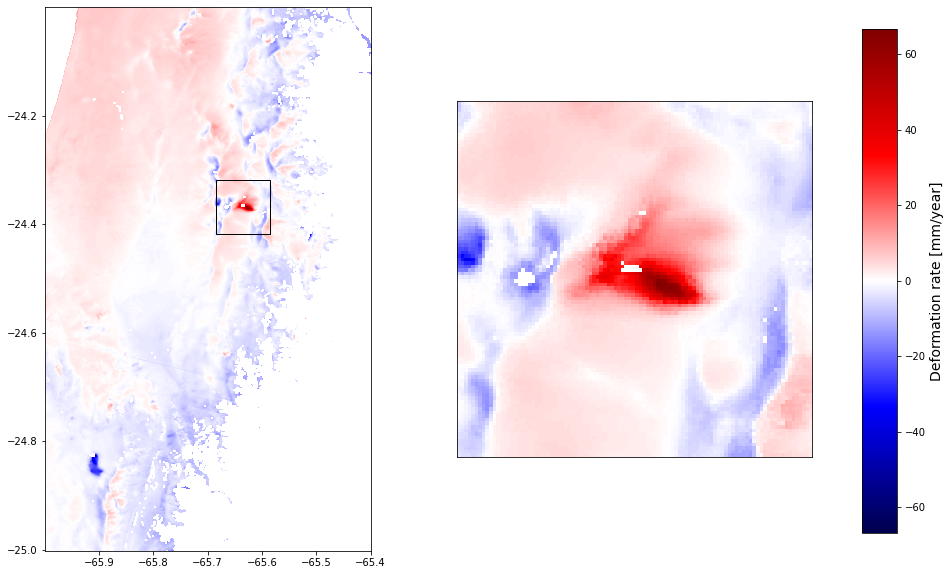

In [4]:
y, x = 368, 365 # Can convert to lat lon
fig, ax = plt.subplots(1, 2, figsize = (14,10))
ax[0].imshow(vel, cmap="seismic", extent=extent,
             vmin=-np.nanmax(vel))

AOI = patches.Rectangle((corner_lon + post_lon*(x-50),
                         corner_lat + post_lat*(y-50)),
                        100*post_lon,100*post_lat, 
                        edgecolor="k", facecolor="none")
ax[0].add_patch(AOI)

ax[1].imshow(vel[y-50:y+50,x-50:x+50], cmap="seismic", 
             vmax = np.nanmax(vel), vmin=-np.nanmax(vel)) 

ax[1].set_xticks([], [])
ax[1].set_yticks([], [])

cax = fig.add_axes([0.95, 0.15, 0.035, 0.7])
norm = mpl.colors.Normalize(vmin=-np.nanmax(vel), 
                            vmax=np.nanmax(vel))
cmap = mpl.cm.seismic
cb1 = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical'
                               )

cb1.set_label('Deformation rate [mm/year]', size=14)

In [5]:
def date2delta(d0, d):
    delta = d - d0
    return delta.days

ts_dict = {"dates" : ds["imdates"][:],
           "data" : ds["cum"][:,y,x]}

ts = pd.DataFrame(ts_dict, index=ts_dict["dates"])
ts.dates = pd.to_datetime(ts.index, format="%Y%m%d")
ts["year"] = ts.apply(lambda x: x.dates.year, axis=1)
ts["month"] = ts.apply(lambda x: x.dates.month, axis=1)
ts["day_of_year"] = ts.apply(lambda x: x.dates.strftime("%j"), axis=1).astype(int)
ts["days"] = ts.apply(lambda x: date2delta(ts.dates.min(), x.dates), axis=1)

In [6]:
linear_reg_coef = np.polyfit(ts.days, ts.data, deg=1)
linear_reg = (linear_reg_coef[0]*ts.days) + linear_reg_coef[1]

linear_reg_coef

array([ 0.11357703, -5.80712144])

In [7]:
diff_detrend = []
ts_arr = ts.data.to_numpy()
for i in range(1, len(ts_arr)):
    diff_detrend.append(ts_arr[i] - ts_arr[i-1])

In [8]:
ts["diff_detrend"] = np.nan

ts["diff_detrend"].iloc[:-1] = diff_detrend.copy()
ts["regresion_rm"] = np.subtract(ts.data,linear_reg)

## Plot time series and trend
First of all, it is important to know that the available data allows to plot 108 unevenly distributed dates starting in late 2015 up to the present. There are also some gaps, with the biggest one between 2017 and 2018. Even though there are many data points, this big gap can lead to possible errors in the results. 

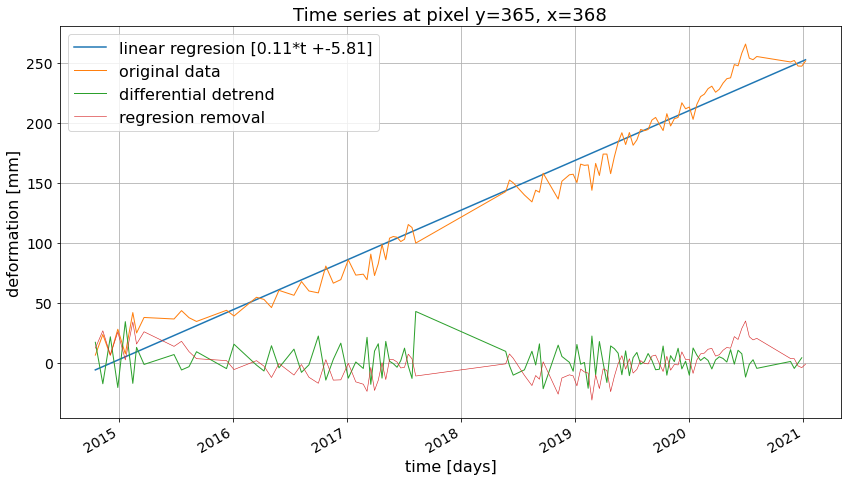

In [9]:
fig, ax = plt.subplots(figsize = (14,8))
ax.plot(ts.dates, linear_reg, 
        label="linear regresion [{:.2f}*t +{:.2f}]".format(linear_reg_coef[0], linear_reg_coef[1]))


ts.plot(x="dates", y="data", ax=ax, label="original data", linewidth=1)
ts.plot(x="dates", y="diff_detrend", ax=ax, label="differential detrend", linewidth=1)
ts.plot(x="dates", y="regresion_rm", ax=ax, label="regresion removal", linewidth=0.6)

plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.legend(fontsize=16)
ax.set_ylabel("deformation [mm]", fontsize=16)
ax.set_xlabel("time [days]", fontsize=16)
ax.set_title("Time series at pixel y={}, x={}".format(x,y), fontsize=18)
plt.show()

For this pixel, the respective time series is plotted and a linear regression is done to have an idea of the long term trend. for this pixel, the trend is 0.11mm/day which is also aprox 40.2mm/yr. After this the trend was removal by 2 methods: subtraction of the regression slope and the differencing method. Oscillations in the time series and in the next plot (time series per year) display a slight seasonal variation, this variation consists on the smaller amplitude (deformation values around +-10mm) of the peaks during the Austral winter and a bigger amplitudes (up to +- 22mm) during the summer.

In [10]:
# Use to fit bigger polynomials
# linear_reg_coef_deg2 = np.polyfit(ts.days, ts.data, deg=3)
# linear_reg_deg2 = ts.days**2 * linear_reg_coef_deg2[0] + \
#                 ts.days**2 * linear_reg_coef_deg2[1] + \
#                 ts.days * linear_reg_coef_deg2[2] + \
#                 linear_reg_coef_deg2[3]

In [11]:
group = ts.groupby(["year", "month"])
monthly_averages = group.aggregate({"diff_detrend":np.nanmean}).reset_index()

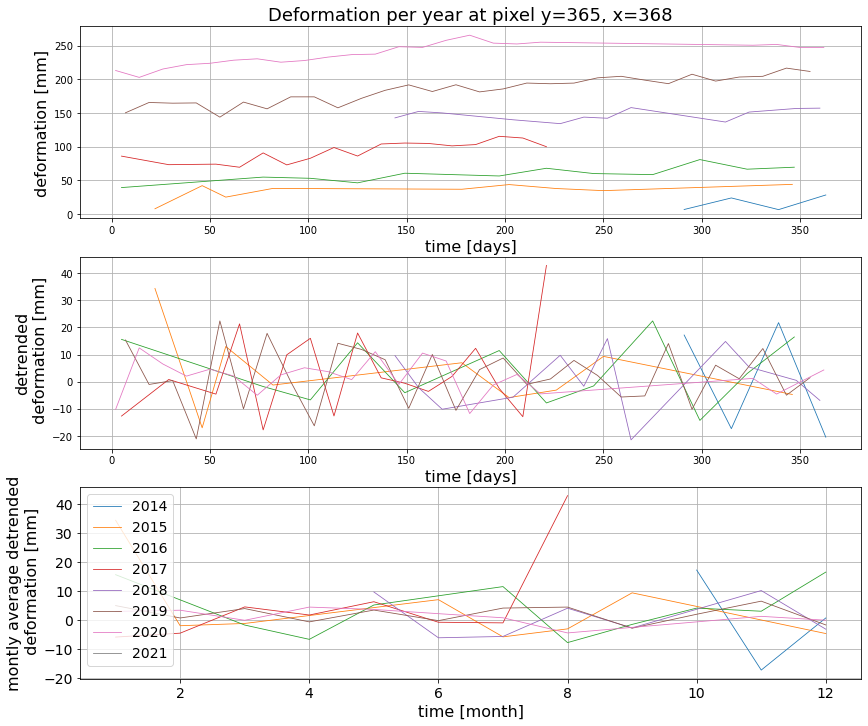

In [12]:
fig, ax = plt.subplots(3,1, figsize = (14,12))
for year in ts.year.unique():
    ts.loc[ts.year == year].plot(x="day_of_year", 
                                 y="data", 
                                 ax=ax[0], label=year,
                                 linewidth=0.8,
                                 legend=False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax[0].legend(fontsize=14)
ax[0].grid(True)
ax[0].set_ylabel("deformation [mm]", fontsize=16)
ax[0].set_xlabel("time [days]", fontsize=16)
ax[0].set_title("Deformation per year at pixel y={}, x={}".format(x,y), fontsize=18)

for year in ts.year.unique():
    ts.loc[ts.year == year].plot(x="day_of_year", 
                                 y="diff_detrend", 
                                 ax=ax[1], label=year,
                                 linewidth=0.8,
                                 legend=False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax[1].legend(fontsize=14)
ax[1].grid(True)
ax[1].set_ylabel("detrended\n deformation [mm]", fontsize=16)
ax[1].set_xlabel("time [days]", fontsize=16)
#ax[1].set_title("Deformation per year at pixel y={}, x={}".format(x,y), fontsize=18)

for year in ts.year.unique():
    monthly_averages.loc[monthly_averages.year == year].plot(x="month", 
                                 y="diff_detrend", 
                                 ax=ax[2], label=year,
                                 linewidth=0.8)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax[2].legend(fontsize=14)
ax[2].set_ylabel("montly average detrended\n deformation [mm]", fontsize=16)
ax[2].set_xlabel("time [month]", fontsize=16)
ax[2].grid(True)
#ax[2].set_title("Deformation per year at pixel y={}, x={}".format(x,y), fontsize=18)
plt.show()

## Time series of the whole landslide

A polygon was created on the velocity image to outline the target landslide, it can be described as a fan shaped landslide with 4 lobes downslope. With all the time series in the landslide linear regression are fitted for each pixel, the results from it look just like the velocity plot form LiCSBAS. after this, the mean, median, and std are measured among the time axis to obtain an estimated mean velocity of the whole landslide. The fact that the median is lower than the mean means that the velocity distribution is skewed towards the lower velocities and that high velocities are a local anomalies that could represent internal zones of the landslide.

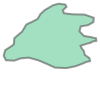

In [13]:
#create geotiff from sample and array
#Run once

tif_out = 'cum_deformation.tif'

if not os.path.isfile(tif_out):
    fid = 'sample_tiff.tif'
    sample_dataset = rasterio.open(fid)
    profile = sample_dataset.profile
    profile.update(count=ts_arr.shape[0])

    array_out = ts_cube.copy()
    with rasterio.open(tif_out, 'w', **profile) as dst:
        dst.write(array_out.astype(rasterio.float32))
        
ts_filepath = 'cum_deformation.tif'
landslide_polygon = gpd.read_file("Landslide_border.gpkg")
landslide_polygon.geometry[0]

In [14]:
# Load the comulative deformation data cube raster
with rasterio.open(tif_out) as src:
    feature = [mapping(landslide_polygon.geometry[0])]
    masked_band = mask(src, feature, crop=True, all_touched=True)
    ts_landslide = masked_band[0]
    pixel_georeferences = masked_band[1]

In [15]:
def get_trend(x):
    """
    Returns a first order polyfit using the days counter from the ts dataframe
    """
    return np.polyfit(ts.days, x, deg=1)
    

regressions = np.apply_along_axis(get_trend,axis=0, arr=ts_landslide) # in mm/day
# first value is the slope, second is the intercept

vel_bins = np.arange(0,np.nanmax(regressions[0,:,:]), 0.005)
vel_hist, vel_bin_edges = np.histogram(regressions[0,:,:], vel_bins)
vel_bin_centers = vel_bin_edges[:-1] + np.diff(vel_bin_edges)/2

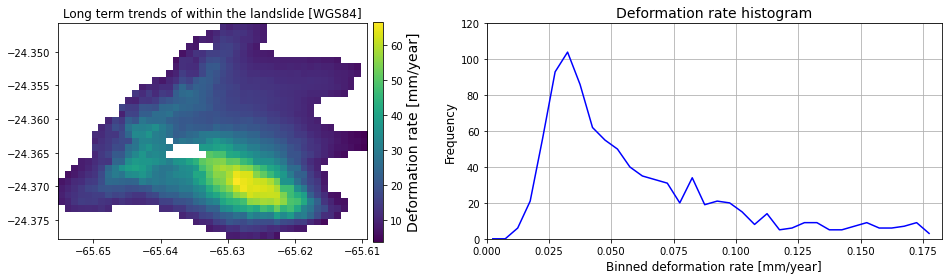

In [16]:
fig, ax = plt.subplots(1,2,  figsize = (14,4))
 
regressions_year_slope = regressions[0,:,:]*365
im = rasterio.plot.show(regressions_year_slope, 
               ax=ax[0], 
               transform=pixel_georeferences)

cax = fig.add_axes([0.425, 0.145, 0.01, 0.765])
norm = mpl.colors.Normalize(vmin=np.nanmin(regressions_year_slope), 
                            vmax=np.nanmax(regressions_year_slope))
cmap = mpl.cm.viridis
cb1 = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical'
                               )

cb1.set_label('Deformation rate [mm/year]', size=14)
ax[0].set_title("Long term trends of within the landslide [WGS84]", size=12)

ax[1].plot(vel_bin_centers, vel_hist, 'b-')
ax[1].set_title('Deformation rate histogram', size=14)
ax[1].set_xlabel('Binned deformation rate [mm/year]', size=12)
ax[1].set_ylabel('Frequency', size=12)
ax[1].grid('on')
ax[1].set(xlim=(0, np.nanmax(regressions[0,:,:])), ylim=(0,120))
plt.tight_layout()
plt.show()

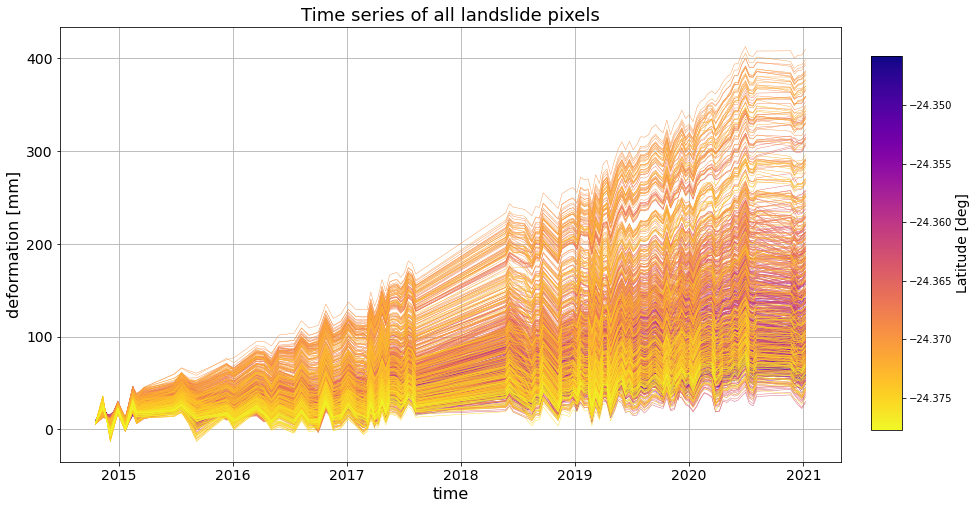

In [17]:
#Plot all time series
ts_plots = ts_landslide.transpose(1, 2, 0).reshape(ts_landslide.shape[1]*ts_landslide.shape[2],
                                                   ts_landslide.shape[0])
map_stripe = ts_plots

#Select a E-W or N-S pixel stripe and plot
#ts_plots = ts_landslide.transpose(1, 2, 0)
#map_stripe = ts_plots[20,::4,:]
colors = plt.cm.plasma(np.linspace(0, 1, map_stripe.shape[0]))

fig, ax = plt.subplots(figsize = (14,8))


for i, ts_unit in enumerate(map_stripe):
    if not np.isnan(ts_unit).all():
        ax.plot(ts.dates,ts_unit, color=colors[i], linewidth=0.4)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

south_border = pixel_georeferences[5]
north_border = pixel_georeferences[5]+ (pixel_georeferences[4]*ts_landslide.shape[1])
#Color code the time series by N-S index (e.g. reds are southmost)
cax = fig.add_axes([0.93, 0.18, 0.03, 0.65])
norm = mpl.colors.Normalize(vmin=south_border, vmax=north_border)
cmap = mpl.cm.plasma_r
cb1 = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical'
                               )
cb1.set_label('Latitude [deg]', size=14)
ax.set_ylabel("deformation [mm]", fontsize=16)
ax.set_xlabel("time", fontsize=16)
ax.set_title("Time series of all landslide pixels".format(x,y), fontsize=18)
plt.show()

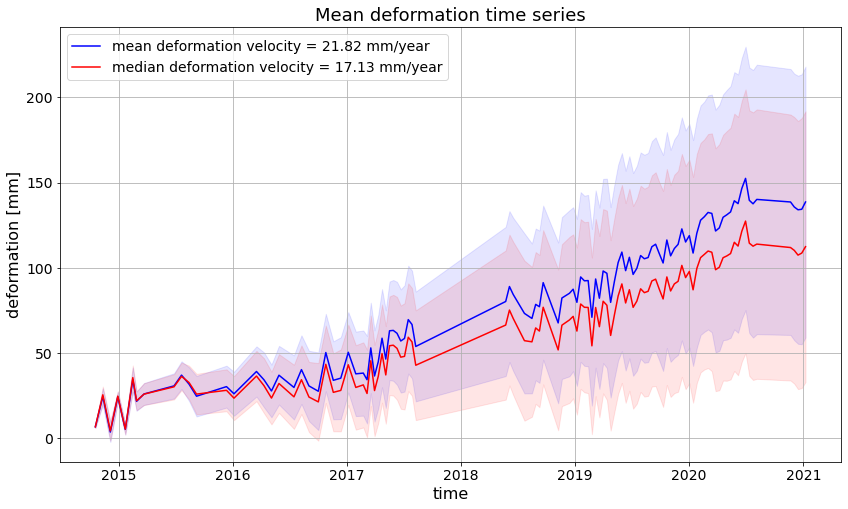

In [18]:
ts_mean_displacement = np.apply_along_axis(np.nanmean,axis=0, arr=ts_plots)
ts_median_displacement = np.apply_along_axis(np.nanmedian,axis=0, arr=ts_plots)
ts_std_displacement = np.apply_along_axis(np.nanstd,axis=0, arr=ts_plots)

fig, ax = plt.subplots(figsize = (14,8))

ax.fill_between(ts.dates,ts_mean_displacement-ts_std_displacement,
                ts_mean_displacement+ts_std_displacement, alpha=0.1, color="b")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.plot(ts.dates,ts_mean_displacement, label="mean deformation velocity = {:.2f} mm/year".format(
    get_trend(ts_mean_displacement)[0]*365), color="b")

ax.fill_between(ts.dates,ts_median_displacement-ts_std_displacement,
                ts_median_displacement+ts_std_displacement, alpha=0.1, color="r")
ax.plot(ts.dates,ts_median_displacement, label="median deformation velocity = {:.2f} mm/year".format(
    get_trend(ts_median_displacement)[0]*365), color="r")

plt.grid()
plt.legend(fontsize=14, loc='upper left')
ax.set_title("Mean deformation time series".format(x,y), fontsize=18)
ax.set_ylabel("deformation [mm]", fontsize=16)
ax.set_xlabel("time", fontsize=16)

plt.show()